## 実装予定リスト
- ネガポジ値算出
- ~~ワードクラウド~~
- ~~共起ネットワーク~~
    1. ~~単語組み合わせ~~
    2. ~~ネットワーク可視化~~
    3. ~~英語対応~~

In [44]:
import numpy as np
import re
import sys
import os
import time
import jaconv
import itertools
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from matplotlib import pyplot as plt, font_manager
from wordcloud import WordCloud
from janome.tokenizer import Tokenizer

font_manager._rebuild()
if os.name=='nt':
    #windows用
    font_dir=font_manager.win32FontDirectory()
else:
    #mac用
    font_dir='/Users/pydata/Library/Fonts/'
font_path=os.path.join(font_dir,'SourceHanCodeJP-Regular.otf')
font=font_manager.FontProperties(fname=font_path,size=14)

def preprocess(text,mode=0):   
    #mode==1で英語対応、mode==0で日本語対応
    if mode==0:
        words = ja_tokenize(text)
    else:
        text = text.lower()
        text = text.replace('.',' .')
        words = text.split(' ')
    
    word_to_id={}
    id_to_word={}
    for word in words:
        if word not in word_to_id:
            new_id=len(word_to_id)
            word_to_id[word]=new_id
            id_to_word[new_id]=word
    
    corpus=np.array([word_to_id[w] for w in words])
    return corpus,word_to_id,id_to_word

def create_co_matrix(corpus,vocab_size,window_size=1):
    corpus_size=len(corpus)
    co_matrix=np.zeros((vocab_size, vocab_size),dtype=np.int32)
    
    for idx, word_id in enumerate(corpus):
        for i in range(1,window_size+1):
            left_idx=idx-i
            right_idx=idx+i
            
            if left_idx>=0:
                left_word_id=corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1
            
            if right_idx<corpus_size:
                right_word_id=corpus[right_idx]
                co_matrix[word_id,right_word_id] += 1
        
    return co_matrix

def cos_similarity(x,y,eps=1e-8):
    nx = x / np.sqrt(np.sum(x**2)+eps)
    ny = y / np.sqrt(np.sum(y**2)+eps)
    return np.dot(nx,ny)

def most_similar(query,word_to_id,id_to_word,word_matrix,top=5):
    #1 take query
    if query not in word_to_id:
        print('%s is not found' %query)
        return
    
    print('\n[query]'+query)
    query_id=word_to_id[query]
    query_vec=word_matrix[query_id]
    
    #2 cal cos similarity
    vocab_size=len(id_to_word)
    similarity=np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i]=cos_similarity(word_matrix[i],query_vec)
    
    count=0
    for i in (-1*similarity).argsort():
        if id_to_word[i] == query:
            continue
        print('%s: %s' %(id_to_word[i], similarity[i]))
        
        count+=1
        if count >= top:
            return

def ppmi(C,verbose=False,eps=1e-8):
    M=np.zeros_like(C,dtype=np.float32)
    N=np.sum(C)
    S=np.sum(C,axis=0)
    total=C.shape[0]*C.shape[1]
    cnt=0
    
    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi=np.log2(C[i,j]*N/(S[j]*S[i])+eps)
            M[i,j]=max(0,pmi)
            
            if verbose:
                cnt+=1
                if cnt % (total/100)==0:
                    print('%.1f%% done' % (100*cnt/total))
    return M        

def plotting(U,height=5,width=5):
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.figure(figsize=(height,width))
    for word, word_id in word_to_id.items():
        plt.annotate(word, (U[word_id, 0],U[word_id,1]))
    plt.scatter(U[:,0],U[:,1],alpha=0.5)
    plt.show()

def ja_tokenize(text):
    ja_tokenizer = Tokenizer()
    res=[]
    stop_words = [u'＇',u"'",u'てる', u'いる', u'なる', u'れる', u'する', u'ある', u'こと', u'これ', u'さん', u'して',u'くれる', u'やる', u'くださる', u'そう', u'せる', u'した',  u'思う',u'それ', u'ここ', u'ちゃん', u'くん', u'', u'て',u'に',u'を',u'は',u'の', u'が', u'と', u'た', u'し', u'で',u'ない', u'も', u'な', u'い', u'か', u'ので', u'よう', u'',u'/\r?\n/g']
    
    #remove char
    text=re.sub('/','',text)
    text=re.sub('セ','',text)
    text=re.sub('{}','',text)
    text=re.sub('　','',text)
    text=re.sub(' ','',text)
    text=re.sub(':','',text)
    text=jaconv.h2z(text,digit=True, ascii=True)
    
    lines=text.split('\n')

    for line in lines:
        malist = ja_tokenizer.tokenize(line)
        for tok in malist:
            ps=tok.part_of_speech.split(",")[0]
            if not ps in ['名詞', '動詞', '形容詞', '形容動詞']: continue
            w=tok.base_form
            if w=="*" or w=="": w=tok.surface
            if w=="" or w=="\n": continue
            if w not in stop_words:
                res.append(w)
        res.append("\n")
    return res

def en_tokenize(text):
    text=re.sub(',','',text)
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    filtered_sentence = []

    for w in word_tokens:
        if w not in stop_words:
            filtered_sentence.append(w)
            
    return filtered_sentence
    
def read_file(filename='cvc_contents.txt'):
    with open(filename, 'r', encoding='utf-8') as f:
        text=f.read()
    text=re.sub('\n','',text)
    return text

def convert_one_hot(corpus, vocab_size):
    """
    convert to one hot vector
    :param corpus: word id list (1 dimension or 2 dimension NumPy array)
    :param vocab_size: vocabulary size
    :return: one-hot vector (2 dimension or 3 dimension NumPy array)
    """
    N = corpus.shape[0]

    if corpus.ndim == 1:
        one_hot = np.zeros((N, vocab_size), dtype=np.int32)

        for idx, word_id in enumerate(corpus):
            one_hot[idx, word_id] = 1

    elif corpus.ndim == 2:
        C = corpus.shape[1]
        one_hot = np.zeros((N, C, vocab_size), dtype=np.int32)
        for idx_0, word_ids in enumerate(corpus):
            for idx_1, word_id in enumerate(word_ids):
                one_hot[idx_0, idx_1, word_id] = 1

    return one_hot

def create_contexts_target(corpus,window_size=1):
    target=corpus[window_size:-window_size]
    contexts=[]
    
    for idx in range(window_size,len(corpus)-window_size):
        cs=[]
        for t in range(-window_size, window_size+1):
            if t == 0:
                continue
            cs.append(corpus[idx+t])
        contexts.append(cs)
    return np.array(contexts), np.array(target)

def display(word_dic,width=10,height=10,top=10):
    %matplotlib inline
    key,value=zip(*word_dic.most_common(top))
    plt.figure(figsize=(height,width))
    plt.bar(key,value,color='orange')
    plt.xticks(rotation=90)
    plt.show()
    
def word_cloud(text,bg_color="white",width=800,height=450):
    #文字列除去
    text=str(text)
    text=re.sub('/\r\n/g','',text)
    text=re.sub("'",'',text)
    
    stop_words = [u'＇',u"'",u'てる', u'いる', u'なる', u'れる', u'する', u'ある', u'こと', u'これ', u'さん', u'して',u'くれる', u'やる', u'くださる', u'そう', u'せる', u'した',  u'思う',u'それ', u'ここ', u'ちゃん', u'くん', u'', u'て',u'に',u'を',u'は',u'の', u'が', u'と', u'た', u'し', u'で',u'ない', u'も', u'な', u'い', u'か', u'ので', u'よう', u'',u'/\r?\n/g']
    wordcloud=WordCloud(background_color=bg_color,font_path="C:\Windows\Fonts\Yu Gothic UI\YuGothM.ttc",width=width,height=height,stopwords=set(stop_words)).generate(text)
    plt.figure(figsize=(15,12))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
#     wordcloud.to_file('./wordcloud.png')

def comb_words(text,mode=0):
    import pandas as pd
    
    if mode == 0:
        sentences=[ja_tokenize(word) for word in text.split('\n')]
    elif mode == 1:
        sentences=[en_tokenaize(word) for word in text.split('.')]
    sentence_combinations=[list(itertools.combinations(sentence,2)) for sentence in sentences]
    sentence_combinations=[[tuple(sorted(words)) for words in sentence] for sentence in sentence_combinations]
    target_combinations=[]
    
    for sentence in sentence_combinations:
        target_combinations.extend(sentence)
    
    count=Counter(target_combinations)
    pd.DataFrame([{'first':i[0][0],'second':i[0][1],'count':i[1]} for i in count.most_common()]).to_csv('kyoki.csv',index=False)
    
def word_network():
    from pyvis.network import Network
    import pandas as pd
    
    got_net=Network(height="1000px", width="95%",bgcolor="#FFFFFF",font_color="black",notebook=True)
    got_net.barnes_hut()
    got_data=pd.read_csv("kyoki.csv")[:150]
    
    sources=got_data['first']#count
    targets=got_data['second']#first
    weights=got_data['count']#second
    
    edge_data=zip(sources, targets, weights)
    
    for e in edge_data:
        src=e[0]
        dst=e[1]
        w=e[2]
        
        got_net.add_node(src,src,title=src)
        got_net.add_node(dst,dst,title=dst)
        got_net.add_edge(src,dst,value=w)
    
    neighbor_map=got_net.get_adj_list()
    
    for node in got_net.nodes:
        node["title"]+=" Neighbors:<br>"+"<br>".join(neighbor_map[node['id']])
        node["value"]=len(neighbor_map[node['id']])
    
    got_net.show_buttons(filter_=['physics'])
    got_net.show('output.html')
    
def similarity(word1,word2,word_to_id):
    if word1 not in word_to_id:
        print('%s is not found' %word1)
        return
    
    if word2 not in word_to_id:
        print('%s is not found' %word2)
        return
    
    return cos_similarity(C[word_to_id[word1]],C[word_to_id[word2]])
    

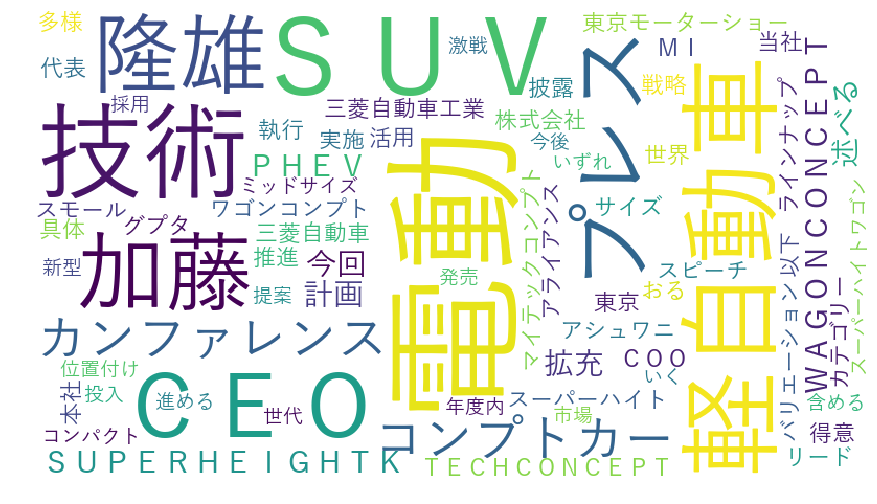

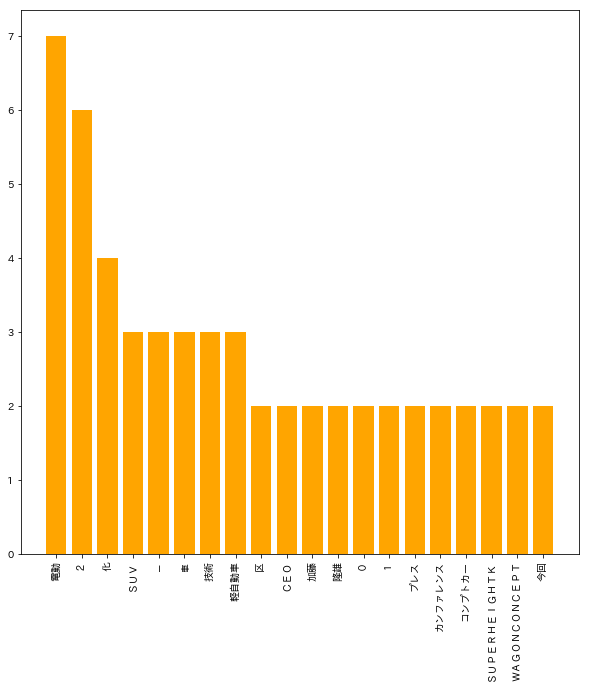

elapsed time preprocess point:  2.3749940395355225
counting co-occurrence...
elapsed time create co-matrix point:  2.4062435626983643
caliculating PPMI...
elapsed time point PPMI:  2.453118324279785
calizulating SVD...
elapsed time point SVD:  2.4687447547912598


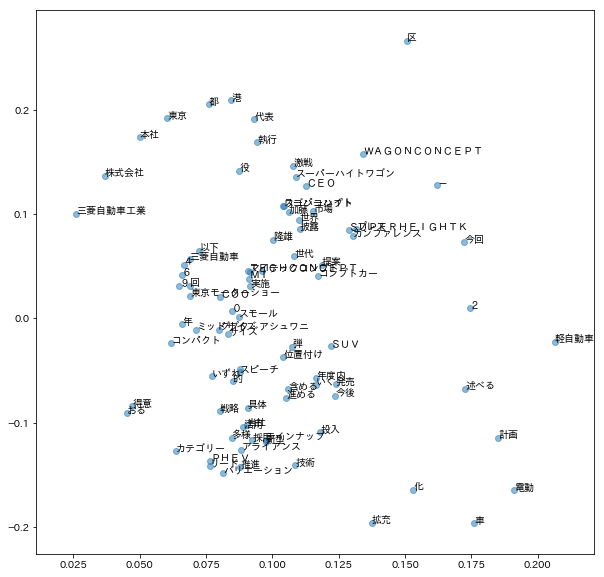

エクリプスクロス is not found
コルト is not found
アウトランダー is not found
三菱 is not found


In [37]:
if __name__ =="__main__":    
    start = time.time()
    text="Artificial sweeteners can make you feel more hungry, despite their calorie-free or low-calorie content, research finds. They have an appetite-stimulating effect on the brain, causing people to eat more and actually increasing the risk of putting on weight."
    text2="三菱自動車工業株式会社(本社：東京都港区、代表執行役CEO：加藤 隆雄、以下三菱自動車)は、第46回東京モーターショー2019*1においてプレスカンファレンスを実施し、スモールサイズの電動SUVコンセプトカー『MI-TECH CONCEPT（マイテックコンセプト）*2』および軽コンセプトカー『SUPER HEIGHT K-WAGON CONCEPT（スーパーハイト軽ワゴンコンセプト）』を世界初披露しました。今回のプレスカンファレンスではCEO加藤隆雄およびCOOグプタ・アシュワニがスピーチし、電動車戦略については「当社は電動化技術、特にPHEVを得意としており、これからもPHEVカテゴリーをリードすべく、さらなるバリエーションの拡充を推進するとともに、アライアンスにおける多様な電動化技術を活用することで、電動車のラインナップを拡充します。具体的には2022年までにミッドサイズSUV、コンパクトSUVに、いずれかの電動化技術を採用した新型車を投入する計画です。今後軽自動車を含め電動化を進めていきます」と述べました。また、軽自動車については「今回提案する『SUPER HEIGHT K-WAGON CONCEPT』は、激戦区であるスーパーハイトワゴン市場に、新世代軽自動車の第2弾の位置付けとして、本年度内の発売を計画しています」と述べました。"  
    text3=read_file()
#     word_cloud(en_tokenize(text))
#     print(en_tokenize(text))
    comb_words(text2,0)
    
    word_cloud(ja_tokenize(text2),bg_color='white')
    word_network()

#     word_count = Counter(en_tokenize(text))
    word_count = Counter(ja_tokenize(text2))
#     print(word_count.most_common(20))
    display(word_count,top=20)
#     print('elapsed time word_count: ',time.time()-start)

    window_size=2
    wordvec_size=100
    corpus,word_to_id,id_to_word=preprocess(text2,0)
    print('elapsed time preprocess point: ',time.time()-start)
    vocab_size=len(word_to_id)
    print('counting co-occurrence...')
    C=create_co_matrix(corpus,vocab_size,window_size)
    print('elapsed time create co-matrix point: ',time.time()-start)
    print('caliculating PPMI...')
    W=ppmi(C,verbose=True)
    print('elapsed time point PPMI: ',time.time()-start)
    print('calizulating SVD...')
    
    try:
        from sklearn.utils.extmath import randomized_svd
        U,S,V=randomized_svd(W,n_components=wordvec_size,n_iter=5,random_state=None)
    except ImportError:
        U,S,V=np.linalg.svd(W)
        
    print('elapsed time point SVD: ',time.time()-start)
    
    word_vecs=U[:,:wordvec_size]
    querys=['エクリプスクロス','コルト','アウトランダー','三菱']
    plotting(U,10,10)
    for query in querys:
        most_similar(query,word_to_id,id_to_word,word_vecs,top=5)
    

#     print('total elapsed time: ',time.time()-start)

In [51]:
a=similarity('化','アライアンス',word_to_id)
a

0.42874646225728813

In [38]:
most_similar('多様',word_to_id,id_to_word, C, top=5)


[query]多様
技術: 0.6390096495174302
含める: 0.4999999987500001
進める: 0.4999999987500001
活用: 0.4999999987500001
アライアンス: 0.4999999987500001


In [26]:
sys.path.append('..')

# text='これはぺんですか？いいえ、ベンです。ケフィアかもしれません。'
corpus,word_to_id,id_to_word=preprocess(text3,1)
vocab_size=len(word_to_id)
C=create_co_matrix(corpus, vocab_size)
W=ppmi(C)

np.set_printoptions(precision=3)
print('covariance matrix')
# print('text:'+ text)
print(C)
print('-'*50)
print('PPMI')
print(W)

covariance matrix
[[   0    1    0 ...    0    0    0]
 [   1    0    1 ...    0    0    0]
 [   0    1 3252 ...    0    0    0]
 ...
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]]
--------------------------------------------------
PPMI
[[ 0.    13.948  0.    ...  0.     0.     0.   ]
 [13.948  0.     1.428 ...  0.     0.     0.   ]
 [ 0.     1.428  1.575 ...  0.     0.     0.   ]
 ...
 [ 0.     0.     0.    ...  0.     0.     0.   ]
 [ 0.     0.     0.    ...  0.     0.     0.   ]
 [ 0.     0.     0.    ...  0.     0.     0.   ]]
